# VAR Model estimation with approximated likelihood ratios

Juan Pavez, Gilles Louppe, Kyle Cranmer, April 2017.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.

In this case an Vector Autoregressive (VAR) model is used. The model is defines as
\begin{equation}
y_t = c + A_1 y_{t-1} + u_t,
\end{equation}
where $y_i \in \mathbb{R}^{Kx1}$, $A_1 \in \mathbb{R}^{KxK}$, $c \in \mathbb{R}^{Kx1}$ and $u_t$ is a white noise process in $K$-dimensions with covariance matrix $\Sigma_u$. 
We approximate the coefficients matrix $A_1 = diag(\alpha_0, \alpha_1)$, with $\alpha_0 = 0.5$ and $\alpha_1 = 0.4$ 
for a 2D VAR(1) process.

We approximate the likelihood of the time series using a recurrent neural network $s(x_{1:T})$ as:

\begin{equation}
\frac{p_{X_{1:T}}(x_{1:T}\vert\theta_0)}{p_{X_{1:T}}(x_{1:T}\vert\theta_1)} = \frac{p_U(u=s(x_{1:T})\vert \theta_0)}{p_U(u=s(x_{1:T})\vert\theta_1)}.
\end{equation}


We also show how to produce the data and train the classifiers in parallel using python multiprocessing.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
import scipy.linalg as L
import pdb
import pickle

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/../systematics/carl')

import carl

import multiprocessing

plt.set_cmap('viridis')

np.random.seed(1234)

sys.setrecursionlimit(10000)

In [2]:
import statsmodels.tsa.vector_ar.var_model as vector_ar

In [3]:
p_value_ = 1
ndims_ = 2
nparams_ = 2
N_ = 5000
T_ = 50
alpha_value_0 = 0.5
alpha_value_1 = 0.4
sigma_2_value = [[1.,0.],[0.,1.]]
intercept=[0.,0.]
alpha_value_0_bkg = 0.3
alpha_value_1_bkg = 0.3
sigma_2_value_bkg = [[1.,0.],[0.,1.]]

target_position = (alpha_value_0, alpha_value_1)
bkg_position = (alpha_value_0_bkg, alpha_value_1_bkg)
bounds = [(0.3, 0.6), (0.3, 0.6)]
n_points = 5

As = np.linspace(bounds[0][0],bounds[0][1], n_points)
Bs = np.linspace(bounds[1][0],bounds[1][1], n_points)
AA, BB = np.meshgrid(As, Bs)
AABB = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))


In [4]:
class VAR:

    def sample(self, coefs, intercept, sigma_2, n_steps, rng=None):
        return vector_ar.util.varsim(coefs, intercept, sigma_2, steps=n_steps)
    
    def plot(self,steps=1000):
        self.VAR.plotsim(steps)

    def nll(self, X, alphas, intercept, sigma_2):
        """
        Compute the negative log likelihood for a VAR process, 
        using formula from Lutkepohl (2005)
        """
        lags = 1
        trend = 'c'
        alpha_0 = alphas[0]
        alpha_1 = alphas[1]
        coefs = np.array([alpha_0,0.,0.,alpha_1]
                        ).reshape(p_value_,ndims_,ndims_)
        
        VAR = vector_ar.VAR(X)
        VAR.k_trend = k_trend = vector_ar.util.get_trendorder(trend)

        offset = 0
        y = VAR.y[offset:]

        z = vector_ar.util.get_var_endog(y, lags, trend, 
                                         has_constant='skip')
        y_sample = y[lags:]
        intercept = intercept
        params = np.vstack((intercept, coefs.reshape((2,2))))
        #params = np.linalg.lstsq(z, y_sample)[0]
        resid = y_sample - np.dot(z, params)
        omega = np.array(sigma_2)
        
        lastterm = -np.trace(np.dot(np.dot(resid, L.inv(omega)),resid.T))
        
        varfit = vector_ar.VARResults(y, z, params, omega, lags, names=VAR.endog_names,
                    trend=trend, dates=VAR.data.dates, model=self)
        llf = -varfit.llf
        llf += 0.5*lastterm
        return -llf
    
    def rvs(self, n_samples, alpha_0, alpha_1, intercept, sigma_2, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        coefs = np.array([alpha_0,0.,0.,alpha_1]
                        ).reshape(p_value_,ndims_,ndims_)
        return self.sample(coefs=coefs,intercept=intercept,
                           sigma_2=sigma_2,
                           n_steps=n_samples,rng=rng)

In [5]:
p0 = VAR()
p1 = VAR()
rng = np.random.RandomState(1234)

n_true = 1
X_true = np.array([p0.rvs(1000, alpha_value_0, alpha_value_1, intercept,
                          sigma_2_value, random_state=np.random.randint(0,5000))
                   for i in range(n_true)])

In [6]:
from itertools import product
bounds_values = [(np.linspace(bounds[0][0],bounds[0][1], num=5)),
                 (np.linspace(bounds[1][0],bounds[1][1], num=5))]
combinations = list(product(*bounds_values))

In [7]:
def produce_data(value):
    return np.array([p0.rvs(T_, value[0], value[1], intercept, sigma_2_value,
                           random_state=np.random.randint(0,5000))
                   for i in range(N_//2)])   

Producing data from the VAR model in parallel using multiprocessing map function.

In [8]:
Xs = []
ys = []
num_cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(num_cores)
Xs = pool.map(produce_data, combinations)
pool.close()
X1_ = np.array([p1.rvs(T_, alpha_value_0_bkg, alpha_value_1_bkg, 
                       intercept, sigma_2_value,
                       random_state=np.random.randint(0,5000))
               for i in range(N_//2)])
Xs = np.array(Xs)

In [9]:
X = Xs[0][0]

Plotting a window from the VAR model.

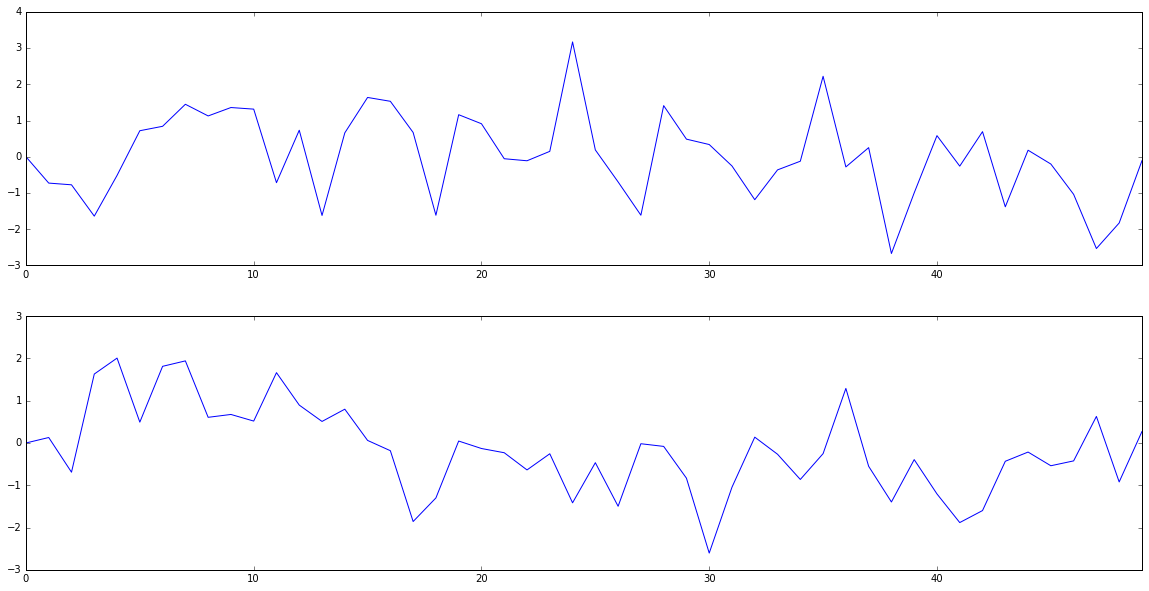

In [10]:
serie1 = X1_[0][:,0]
serie2 = Xs[0][0][:,0]
plt.figure(figsize=(20,10))
plt.subplot(211)
ts1 = pd.Series(serie1)
ts1.plot()
plt.subplot(212)
ts2 = pd.Series(serie2)
ts2.plot()

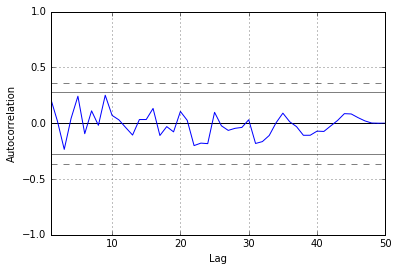

In [11]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(ts1)

In [12]:
max_len = 8

def pad_sequence(X, max_len=10):
    X_serie = []
    for x in X:
        for i in xrange(x.shape[0]-max_len+1):
            X_serie.append(x[i:i+max_len])
    X_serie = np.array(X_serie)
    #X_serie = X_serie[np.random.choice(X_serie.shape[0],
    #                                   X_serie.shape[0],replace=False)]
    return X_serie

Xs_series = []

for n in range(len(combinations)):
    X0 = Xs[n]
    Xs_series.append(pad_sequence(X0, max_len=max_len))

Xs_series = Xs_series
X1_series = pad_sequence(X1_, max_len=max_len)

In [13]:
Xs_series[0][0].shape

(8, 2)

In [14]:
def covariances(X, k, u):
    if len(X.shape) > 1:
        N = X.shape[1]
    else:
        N = X.shape[0]
    return (1./(N-1))* (np.array([(X[:,i+k] - u)*(X[:,i] - u) 
                                      for i in range(N-k)])).sum(axis=0)

# Need to code it for more lags
def differences(X):
    if len(X.shape) > 1:
        X_ = np.zeros((X.shape[0], X.shape[1]-1))
        for k in range(len(X)):
            X_[k] = X[k][1:] - X[k][:-1]
        return X_
    return X[1:] - X[:-1]

def normalize(X):
    if len(X.shape) > 1:
        return X - X.mean(axis=1, keepdims=True)
    return X - X.mean()

    
def compute_S(Xs):
    # Autocovariances to lag 5
    u_x = Xs.mean(axis=1)
    covs_x = np.array([covariances(Xs, k, u_x) for k in range(max_len - 1)])
    # Number of zeros observed
    #zeros_x = (Xs == 0.).sum(axis=1)
    S_x = [np.hstack((covs_x[:,k].flatten(), u_x[k]))
           for k in range(Xs.shape[0])]
    return S_x

In [15]:
for n in range(len(combinations)):
    X0 = Xs_series[n]
    Xs_series[n] = compute_S(X0)
X1_series = compute_S(X1_series)

In [16]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit


Using Theano backend.


Defining the RNN (in this case GRU) classifier to approximate the likelihood ratio.

In [17]:
def make_model_join():
    model = Sequential()
    model.add(GRU(15, input_shape=(max_len, ndims_,)))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    sgd = Adam(clipnorm=40.)
    model.compile(loss="binary_crossentropy", optimizer='adam')
    return model

In [18]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
def make_ratio_nosec(num):
    X_num = Xs_series[num]
    X_den = X1_series
    X = np.vstack((X_num, X_den))
    y = np.zeros(len(X_num) + len(X_den), dtype=np.int)
    y[len(X_num):] = 1

    clf = ExtraTreesClassifier(n_estimators=100, min_samples_split=20, random_state=0, n_jobs=-1)
    #clf = KerasClassifier(make_model_join, nb_epoch=50, verbose=0)

    cv =  StratifiedShuffleSplit(n_iter=3, test_size=0.5, random_state=1)

    ratio = ClassifierRatio(
        base_estimator=CalibratedClassifierCV(clf, cv=cv, bins=20),
        random_state=0)
    ratio.fit(X, y)
    
    #print('Loss {0} : {1}'.format(num, log_loss(ratio.classifier_.classifiers_[0].
    #               predict(X[:int(len(X)*0.3)]),y[:int(len(X)*0.3)])))
    
    return ratio

def make_ratio(num):
    X_num = Xs[num]
    X_den = X1_
    X = np.vstack((X_num, X_den))
    y = np.zeros(len(X_num) + len(X_den), dtype=np.int)
    y[len(X_num):] = 1

    clf = KerasClassifier(make_model_join, nb_epoch=50, verbose=0)

    cv =  StratifiedShuffleSplit(n_iter=1, test_size=0.5, random_state=1)

    ratio = ClassifierRatio(
        base_estimator=CalibratedClassifierCV(clf, cv=cv, bins=20),
        random_state=0)
    ratio.fit(X, y)

    return ratio


Training the classifiers at each grid point in parallel.

In [20]:
print('Start training')
#num_cores = multiprocessing.cpu_count()
#pool = multiprocessing.Pool(num_cores)

clf_ratios = []
n_sample_points = len(combinations)
points = list(range(n_sample_points))
for i, k in enumerate(points):
    print('Model {0}'.format(i))
    clf_ratios.append(make_ratio_nosec(k))
#for i, k in enumerate([points[n:n + num_cores] for n in range(0, n_sample_points, num_cores)]):
#    print('Iteration {0}'.format(i))
#    clf_ratios += pool.map(make_ratio, k)
#pool.close()
print('End training')

Start training
Model 0
Model 1
Model 2
Model 3
Model 4
Model 5
Model 6
Model 7
Model 8
Model 9
Model 10
Model 11
Model 12
Model 13
Model 14
Model 15
Model 16
Model 17
Model 18
Model 19
Model 20
Model 21
Model 22
Model 23
Model 24
End training


In [21]:
X_true = np.array([p0.rvs(1000, alpha_value_0, alpha_value_1, intercept,
                          sigma_2_value, random_state=np.random.randint(0,5000))
                   for i in range(n_true)])

In [22]:
X_true_serie = pad_sequence(X_true, max_len=max_len)
X_true_serie = compute_S(X_true_serie)

In [23]:
len(clf_ratios)

25

In [24]:
llr = []
zeros = []
distances = []

for i, theta in enumerate(combinations):
    print(i, theta)
    ratio = clf_ratios[i]
    ratios = ratio.predict(X_true_serie, log=True)
    print ratios[np.isinf(ratios)].shape
    zeros.append(ratios[np.isinf(ratios)].shape[0])
    ratios = ratios[np.logical_and(np.isfinite(ratios),~np.isnan(ratios))]
    nllr = -np.sum(ratios) 
    llr.append(nllr)
    print(llr[-1])

(0, (0.29999999999999999, 0.29999999999999999))
(0,)
-8.85274771678
(1, (0.29999999999999999, 0.375))
(0,)
-32.3131024783
(2, (0.29999999999999999, 0.44999999999999996))
(0,)
21.2084012911
(3, (0.29999999999999999, 0.52499999999999991))
(0,)
115.475973067
(4, (0.29999999999999999, 0.59999999999999998))
(0,)
210.673856469
(5, (0.375, 0.29999999999999999))
(0,)
-144.817404152
(6, (0.375, 0.375))
(0,)
-147.896913364
(7, (0.375, 0.44999999999999996))
(0,)
-99.4750250783
(8, (0.375, 0.52499999999999991))
(0,)
0.560336179495
(9, (0.375, 0.59999999999999998))
(0,)
120.784215085
(10, (0.44999999999999996, 0.29999999999999999))
(0,)
-248.391124853
(11, (0.44999999999999996, 0.375))
(0,)
-261.378121866
(12, (0.44999999999999996, 0.44999999999999996))
(0,)
-224.733904987
(13, (0.44999999999999996, 0.52499999999999991))
(0,)
-121.645982952
(14, (0.44999999999999996, 0.59999999999999998))
(0,)
14.2721716818
(15, (0.52499999999999991, 0.29999999999999999))
(0,)
-277.124942408
(16, (0.524999999999999

In [25]:
llr = np.array(llr)
llr[np.isnan(llr)] = 0.
llr /= len(X_true)

Computing exact likelihood at same points in order to compare results.

In [26]:
# Computing exact likelihood
exact_contours = np.zeros(len(AABB))
combinations = product(As, Bs)
i = 0
for a in As:    
    for b in Bs:
        exact_contours[i] = np.sum([p0.nll(X_true[k], [a,b], intercept, sigma_2_value) 
                                     for k in range(n_true)])
        i += 1

In [27]:
exact_contours /= len(X_true)
#llr, zeros = pickle.load(open('data/ar_results.dat', 'r'))

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern


# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.1f' % self.__float__()
        else:
            return '%.1f' % self.__float__()

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '


In [29]:
len(X_true)

1

/afs/cern.ch/user/j/jpavezse/.local/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:304: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


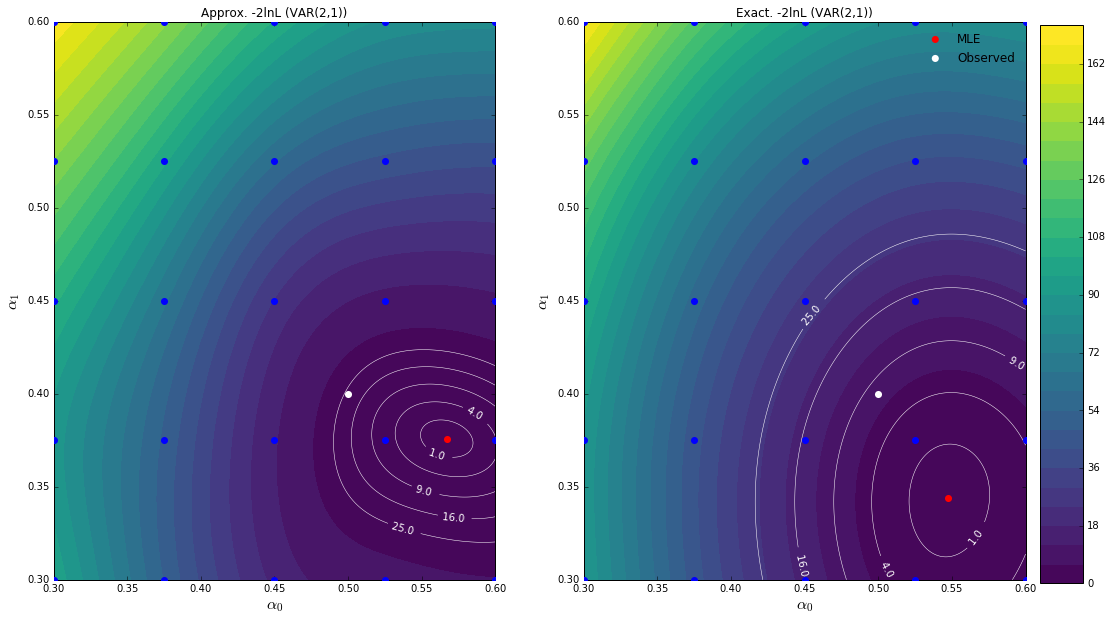

In [30]:
thetas = np.array([v for v in product(As, Bs)])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax = axes.flat[0]

gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, llr)

xi = np.linspace(bounds[0][0], bounds[0][1], 500)
yi = np.linspace(bounds[1][0], bounds[1][1], 500)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.

cs = ax.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
cs.levels = [nf(val) for val in cs.levels]
ax.clabel(cs, cs.levels, inline=1, fontsize=10, fmt = fmt)
cs = ax.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)

#plt.colorbar()
ax.scatter(thetas[:,0],thetas[:,1], marker='o', c='b', s=50, lw=0, zorder=10)
ax.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
ax.scatter([alpha_value_0],[alpha_value_1], marker='o', c='w', s=50, lw=0, zorder=10)

ax.set_xlim(bounds[0][0], bounds[0][1])
ax.set_ylim(bounds[1][0], bounds[1][1])
ax.set_xlabel(r"$\alpha_0$", size=16)
ax.set_ylabel(r"$\alpha_1$", size=16)
ax.set_title("Approx. -2lnL (VAR(2,1))")

ax = axes.flat[1]

gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, exact_contours)

xi = np.linspace(bounds[0][0], bounds[0][1], 500)
yi = np.linspace(bounds[1][0], bounds[1][1], 500)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.

cs2 = ax.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
cs2.levels = [nf(val) for val in cs2.levels]
ax.clabel(cs2, cs2.levels, inline=1, fontsize=10, fmt = fmt)
cs2 = ax.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.12, 0.03, 0.775])
fig.colorbar(cs2, cax=cbar_ax)

ax.scatter(thetas[:,0],thetas[:,1], marker='o', c='b', s=50, lw=0, zorder=10)
smle = ax.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
sobs = ax.scatter([alpha_value_0],[alpha_value_1], marker='o', c='w', s=50, lw=0, zorder=10)

lines = [smle, sobs]
labels = ['MLE', 'Observed']

ax.legend(lines, labels, frameon=False, prop={'size':12}, scatterpoints=1)

ax.set_xlim(bounds[0][0], bounds[0][1])
ax.set_ylim(bounds[1][0], bounds[1][1])
ax.set_xlabel(r"$\alpha_0$", size=16)
ax.set_ylabel(r"$\alpha_1$", size=16)
ax.set_title("Exact. -2lnL (VAR(2,1))")

plt.show()
#plt.savefig('ar_2d_approx.pdf')

In [31]:
thetas = np.array([v for v in product(As, Bs)])
xi = np.linspace(bounds[0][0], bounds[0][1], 500)
yi = np.linspace(bounds[1][0], bounds[1][1], 500)

xx, yy = np.meshgrid(xi, yi)

def fit_gp(llr):
    gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
                                  kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
    gp.fit(thetas, llr)

    zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
    zi = zz.reshape(xx.shape)

    mle = np.unravel_index(zi.argmin(),zi.shape)
    return mle

In [36]:
n_hist = 200
#mles = []
#exact_mles = []
mles = list(mles)
exact_mles = list(exact_mles)

for n in range(n_hist):
    print(n),
    X_true = np.array([p0.rvs(1000, alpha_value_0, alpha_value_1, intercept,
                              sigma_2_value, random_state=np.random.randint(0,5000))
                       for i in range(n_true)])

    X_true_serie = pad_sequence(X_true, max_len=max_len)
    X_true_serie = compute_S(X_true_serie)

    
    exact_contours = np.zeros(len(AABB))
    combinations = product(As, Bs)
    i = 0
    for a in As:    
        for b in Bs:
            exact_contours[i] = np.mean([p0.nll(X_true[k], [a,b], intercept, sigma_2_value) 
                                         for k in range(n_true)])
            i += 1
    
    llr = []

    for i, theta in enumerate(combinations):
        ratio = clf_ratios[i]
        ratios = ratio.predict(X_true_serie, log=True)
        ratios = ratios[np.logical_and(np.isfinite(ratios),~np.isnan(ratios))]
        nllr = -np.mean(ratios) 
        llr.append(nllr)

    mles.append(fit_gp(llr))
    exact_mles.append(fit_gp(exact_contours))


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199


In [37]:
mles = np.array(mles)
exact_mles = np.array(exact_mles)

min_pos = np.array([(xi[mle[1]], yi[mle[0]]) for mle in mles])
exact_min_pos = np.array([(xi[mle[1]], yi[mle[0]]) for mle in exact_mles])

In [34]:
pickle.dump([mles, exact_mles], open('data/mles_temp_1000.dat', 'w'))

Alpha 0, exact: 0.500775551102 +/- 0.0274343450181, approx: 0.494923847695 +/- 0.0283142725375, real: 0.5
Alpha 1, exact: 0.402166332665 +/- 0.0260427252271, approx: 0.408679358717 +/- 0.0303836523257, real: 0.4


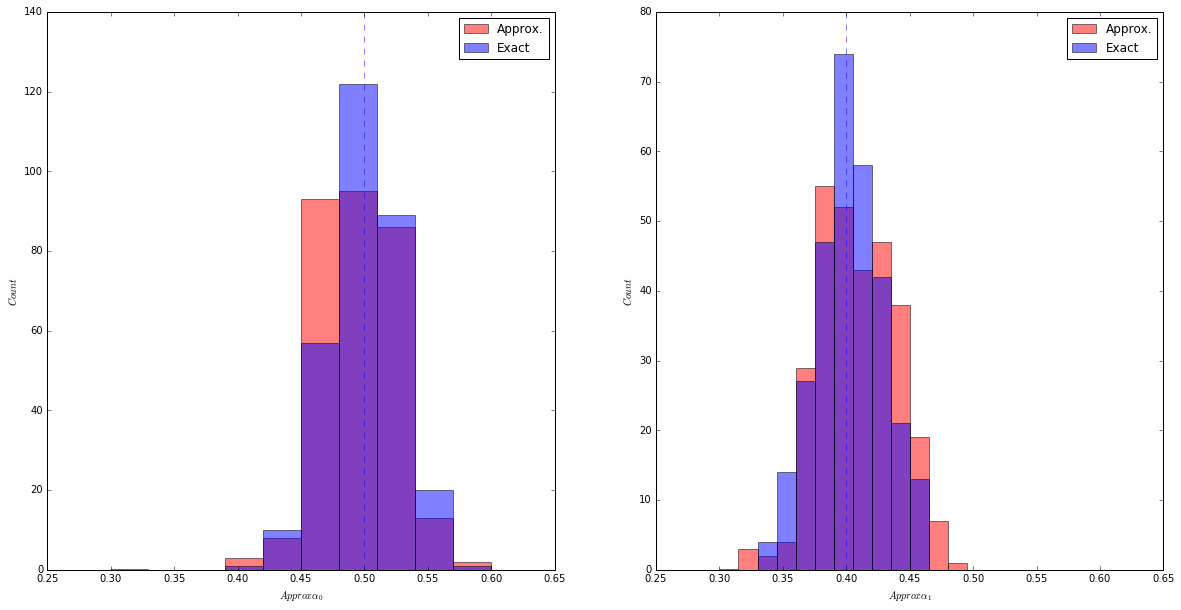

In [39]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)

print('Alpha 0, exact: {0} +/- {1}, approx: {2} +/- {3}, real: {4}'.format(
        np.mean(exact_min_pos[:,0]),np.std(exact_min_pos[:,0]),
        np.mean(min_pos[:,0]), np.std(min_pos[:,0]),
        alpha_value_0))
print('Alpha 1, exact: {0} +/- {1}, approx: {2} +/- {3}, real: {4}'.format(
        np.mean(exact_min_pos[:,1]),np.std(exact_min_pos[:,1]),
        np.mean(min_pos[:,1]), np.std(min_pos[:,1]),
        alpha_value_1))

ax1.hist(min_pos[:,0], label='Approx.' ,alpha=0.5, color='r', bins=10, range=(0.3,0.6))
ax1.hist(exact_min_pos[:,0], label='Exact', alpha=0.5, color='b', bins=10, range=(0.3,0.6))
ax1.set_xlabel(r"$Approx \alpha_0$")
ax1.set_ylabel(r"$Count$")

ax1.legend()
ax1.axvline(x=alpha_value_0,linestyle='dashed',alpha=0.5)

ax2 = fig.add_subplot(1,2,2)

ax2.hist(min_pos[:,1], label='Approx.' ,alpha=0.5, color='r', bins=20, range=(0.3,0.6))
ax2.hist(exact_min_pos[:,1], label='Exact', alpha=0.5, color='b', bins=20, range=(0.3,0.6))
ax2.set_xlabel(r"$Approx \alpha_1$")
ax2.set_ylabel(r"$Count$")

ax2.legend()
ax2.axvline(x=alpha_value_1,linestyle='dashed',alpha=0.5)
#plt.savefig('likelihood_comp.pdf')
plt.show()

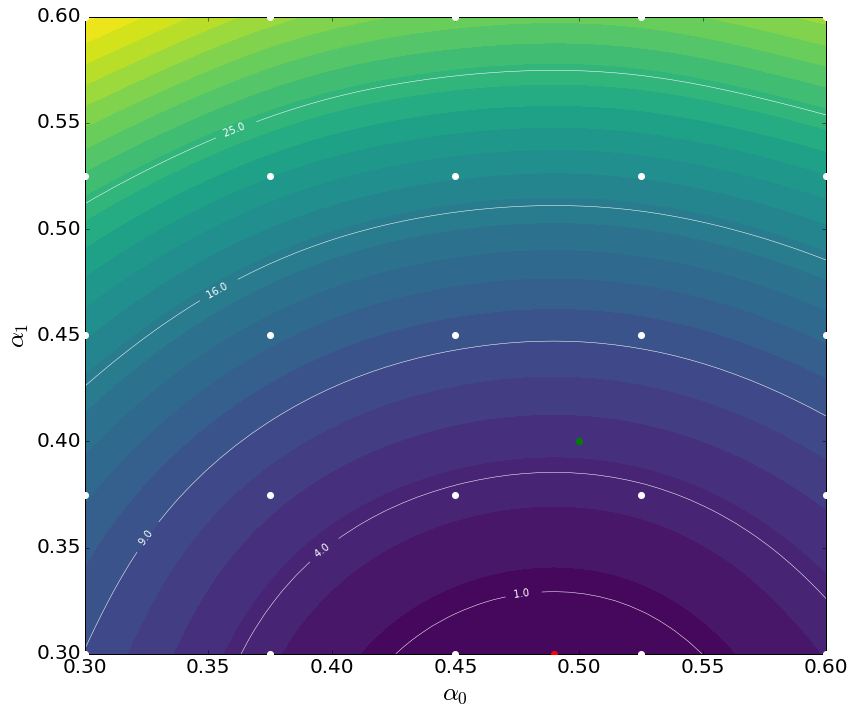

In [84]:
thetas = np.array([v for v in product(As, Bs)])

gp = GaussianProcessRegressor(alpha=0., normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, exact_contours)

xi = np.linspace(bounds[0][0], bounds[0][1], 50)
yi = np.linspace(bounds[1][0], bounds[1][1], 50)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.

cs = plt.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
plt.clabel(cs, cs.levels, inline=1, fontsize=10, fmt = fmt)

cs = plt.contourf(xi, yi, zi, 30,
                  vmax=abs(zi).max(), vmin=0.0)

#plt.colorbar()
plt.scatter(thetas[:,0],thetas[:,1], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([alpha_value_0],[alpha_value_1], marker='o', c='g', s=50, lw=0, zorder=10)

plt.xlim(bounds[0][0], bounds[0][1])
plt.ylim(bounds[1][0], bounds[1][1])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel(r"$\alpha_0$", fontsize=25)
plt.ylabel(r"$\alpha_1$", fontsize=25)
plt.tight_layout()
#plt.savefig('plots/alpha_gp_exact.pdf')
plt.show()

In [41]:
alpha_value_1

0.4

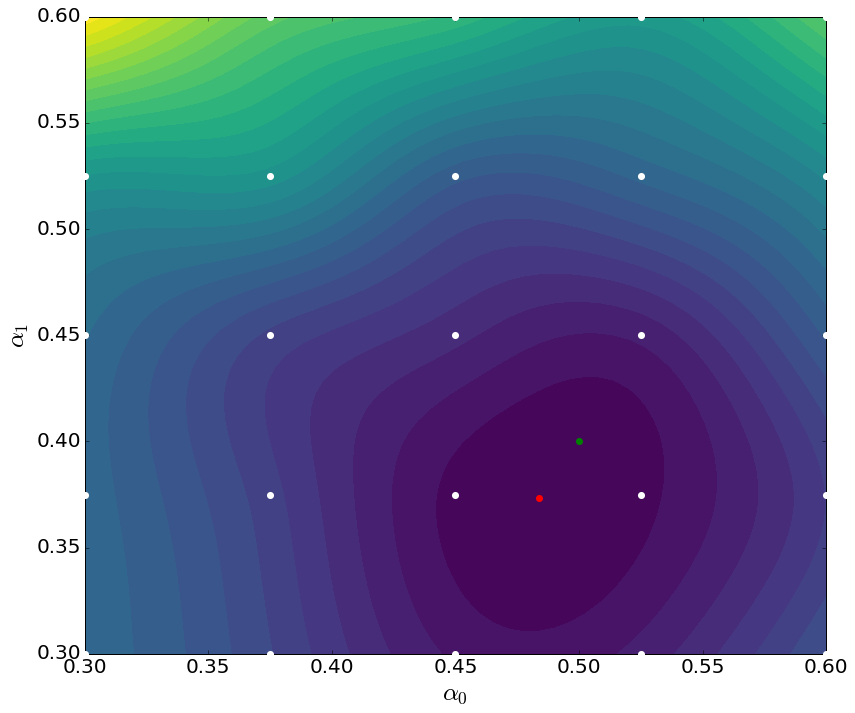

In [42]:
thetas = np.array([v for v in product(As, Bs)])

gp = GaussianProcessRegressor(alpha=0., normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, llr)

xi = np.linspace(bounds[0][0], bounds[0][1], 50)
yi = np.linspace(bounds[1][0], bounds[1][1], 50)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.

cs = plt.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
plt.clabel(cs, cs.levels, inline=1, fontsize=10, fmt = fmt)

cs = plt.contourf(xi, yi, zi, 30,
                  vmax=abs(zi).max(), vmin=0.0)

#plt.colorbar()
plt.scatter(thetas[:,0],thetas[:,1], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([alpha_value_0],[alpha_value_1], marker='o', c='g', s=50, lw=0, zorder=10)

plt.xlim(bounds[0][0], bounds[0][1])
plt.ylim(bounds[1][0], bounds[1][1])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel(r"$\alpha_0$", fontsize=25)
plt.ylabel(r"$\alpha_1$", fontsize=25)
plt.tight_layout()
#plt.savefig('plots/alpha_gp_approx.pdf')
plt.show()

Plot grid of score distributions to check calibration

In [42]:
from carl.ratios.utils import plot_scores

In [25]:
combinations = list(combinations)

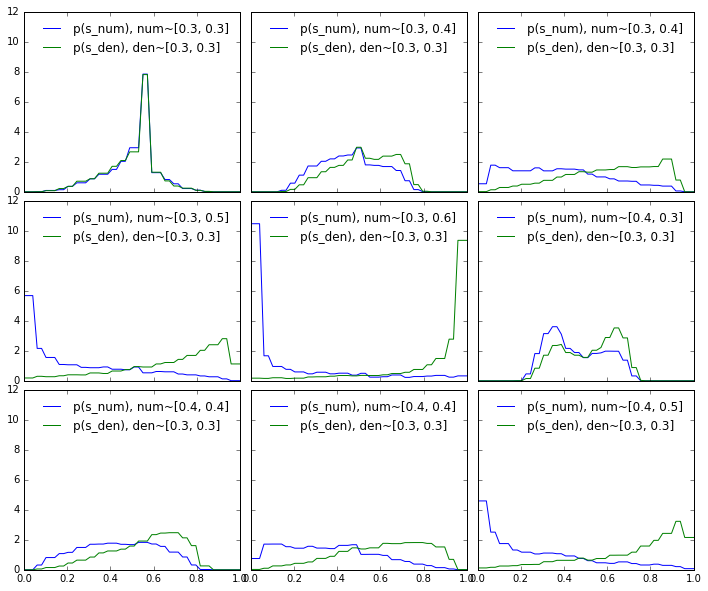

In [45]:
plot_scores(clf_ratios[0:9], 
            num_den_labels=[(l,bkg_position) for l in combinations[0:9]])

# Simple ABC Estimation

In [32]:
import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
sys.path.insert(0, cmd_folder + '/abc/SIMPLE-ABC')

In [33]:
from simple_abc import Model, basic_abc, pmc_abc
from scipy import stats

In [55]:
class MyModel(Model):
    
    #This method initializes the model object. In this case it does nothing, but you can have you model 
    #do something when the model object is created, like read in a table of something. 
    def __init__(self):
        pass
    
    #This is the method that draws from you prior. In this example it draws from frozen scipy.stats 
    #distributions that are set with the Model.set_priors method.
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta
    
    #The method that generates the synthetic data sets.
    def generate_data(self, theta, size=50):
        return p0.rvs(size, theta[0], theta[1], intercept,
                          sigma_2_value, random_state=np.random.randint(0,5000))
    
    
    #The method that computes your summary statistics, for a Gaussian we just need mu and sigma
    def summary_stats(self, data):
        u_x = data.mean(axis=0)
        covs_x = np.array([covariances(np.array([data]), k, u_x) 
                           for k in range(max_len - 1)])
        # Number of zeros observed
        #zeros_x = (Xs == 0.).sum(axis=1)
        S_x = np.hstack((covs_x.flatten(), u_x))
        return (S_x)
    
    #And finally the distance function. We are just going to use the euclidean distance 
    #from our observed summary stats
    def distance_function(self, data, synth_data):
        return np.mean(np.abs(data - synth_data))

In [97]:
#loc_0, scale_0 = 0.5*(bounds[0][0]+bounds[0][1]), 0.5*(bounds[0][1]-bounds[0][0])
#loc_1, scale_1 = 0.5*(bounds[1][0]+bounds[1][1]), 0.5*(bounds[1][1]-bounds[1][0])
loc_0, scale_0 = bounds[0][0], bounds[0][1]-bounds[0][0]
loc_1, scale_1 = bounds[1][0], bounds[1][1]-bounds[1][0]

print(loc_0, scale_0, loc_1, scale_1)

#Set a random seed 
np.random.seed(1234)

#Initialize our model object
model = MyModel()

#Make our "observed" data. Let's use the model's generate_data method.
data = model.generate_data([alpha_value_0, alpha_value_1], size=1000)

#Now we need to set the prior distributions. We were clever and set up our draw theta method to call 
#frozen scipy.stats objects, so we jest need to give the model our prior distributions 
model.set_prior([stats.uniform(loc=loc_0,scale=scale_0),
                stats.uniform(loc=loc_1, scale=scale_1)])

#And while we are at it, we will give the model our observed data as well
model.set_data(data)


(0.3, 0.3, 0.3, 0.3)


In [106]:
posterior = basic_abc(model, data, min_samples=50, epsilon=1)

In [105]:
model.prior[0].rvs()

0.5445488802153007

(0.3, 0.6)

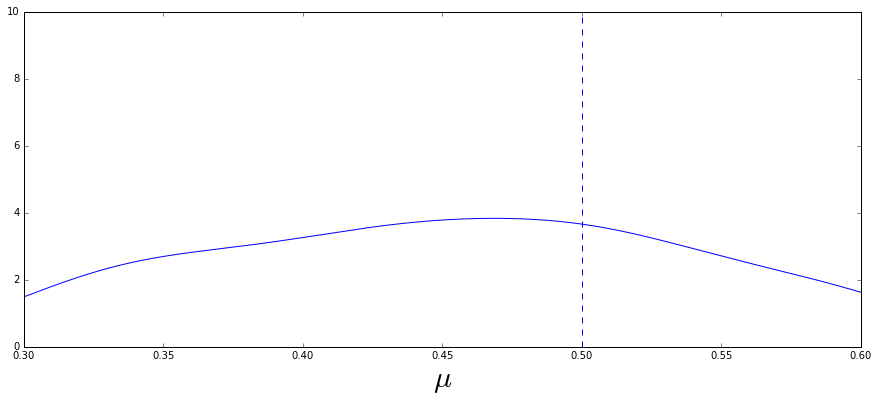

In [107]:
mu = posterior[0][0]

mukde = stats.gaussian_kde(mu)

plt.figure(figsize=(15,6))
plt.subplots_adjust(wspace=0.2)
plt.subplot(111)
#plt.hist(mu,normed=True)
x = np.linspace(bounds[0][0],bounds[0][1],1000)
plt.plot(x, mukde(x))
plt.axvline(alpha_value_0, ls="--")
plt.xlabel(r"$\mu$", fontsize=30)
plt.ylim(0,10)
plt.xlim(bounds[0][0],bounds[0][1])

In [108]:
pmc_posterior = pmc_abc(model, data, epsilon_0=1, min_samples=50, steps=15)

Starting step 0
Starting step 1
Starting step 2
Starting step 3
Starting step 4
Starting step 5
Starting step 6
Starting step 7
Starting step 8
Starting step 9
Starting step 10
Starting step 11
Starting step 12
Starting step 13
Starting step 14


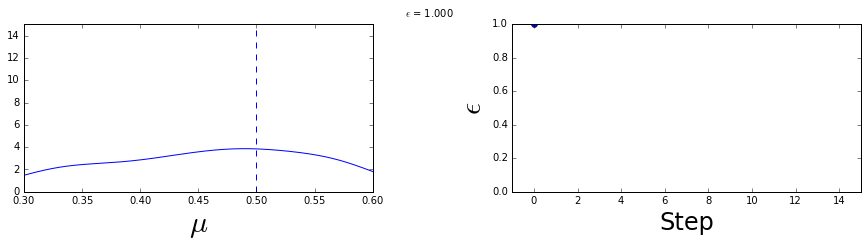

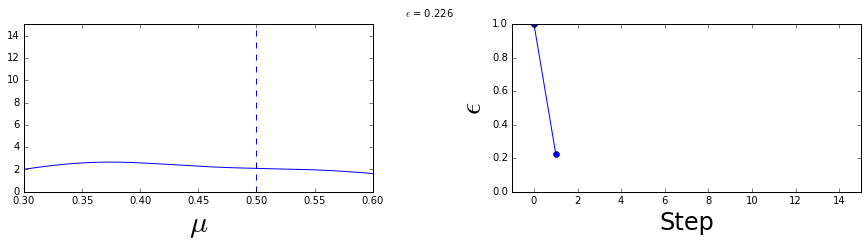

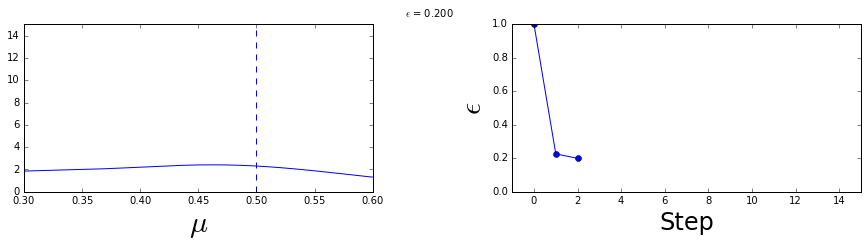

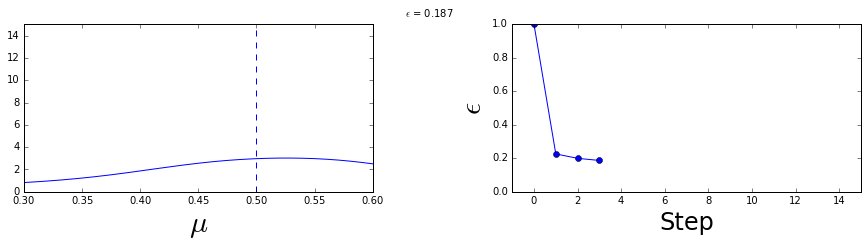

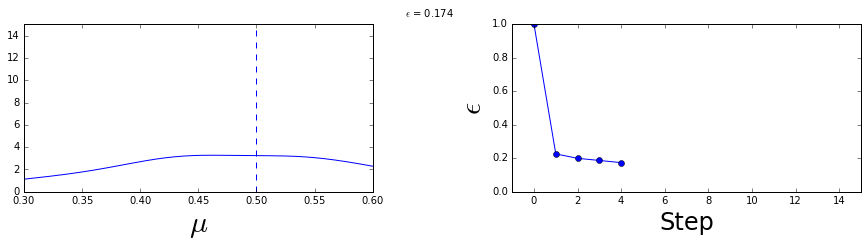

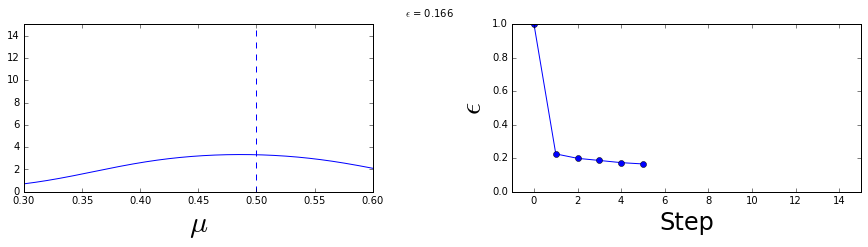

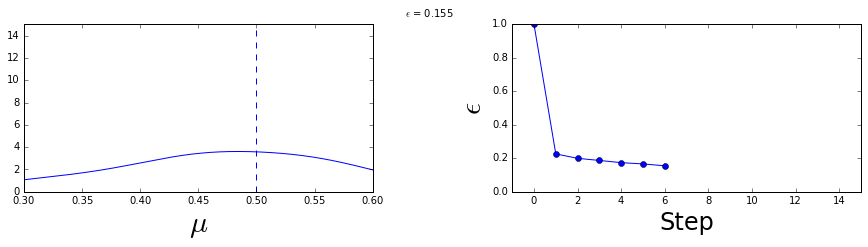

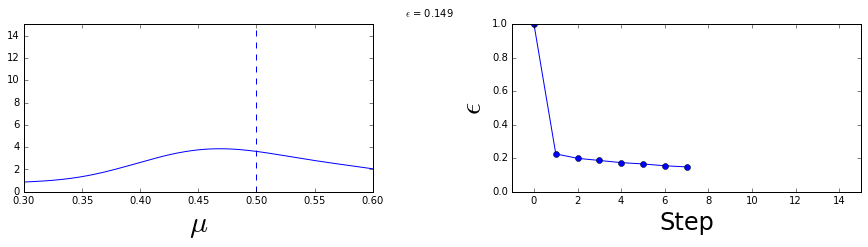

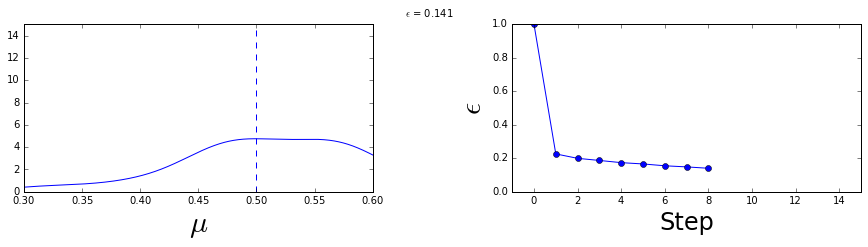

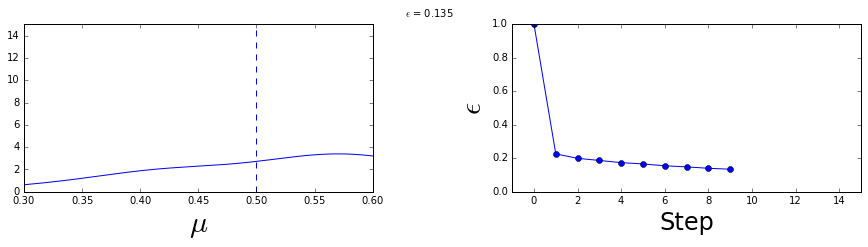

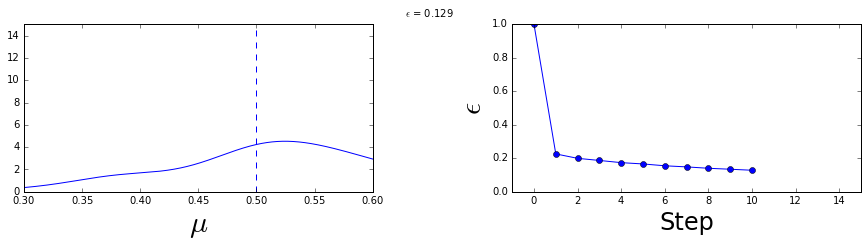

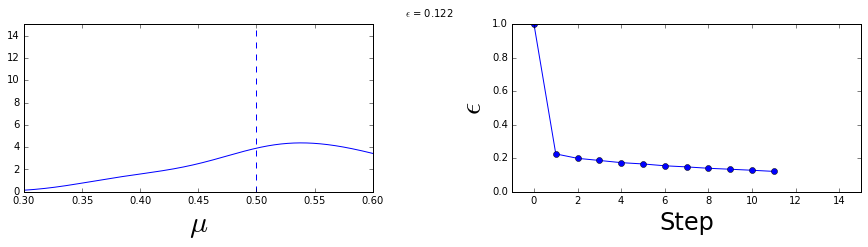

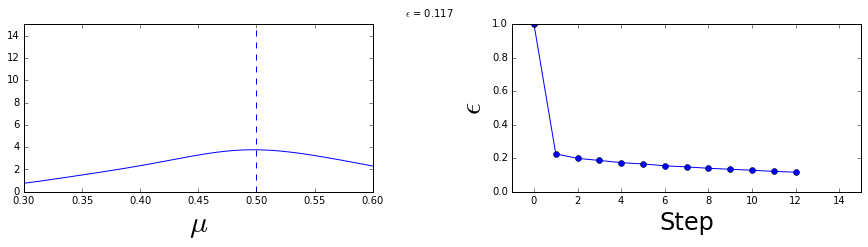

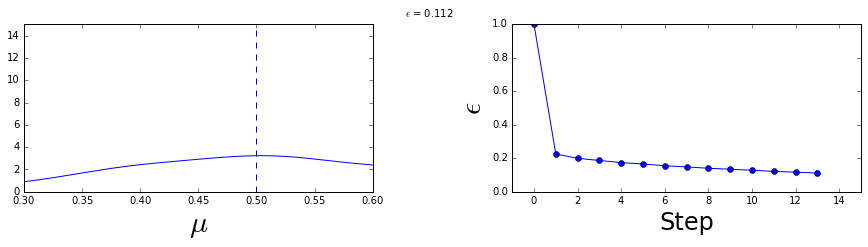

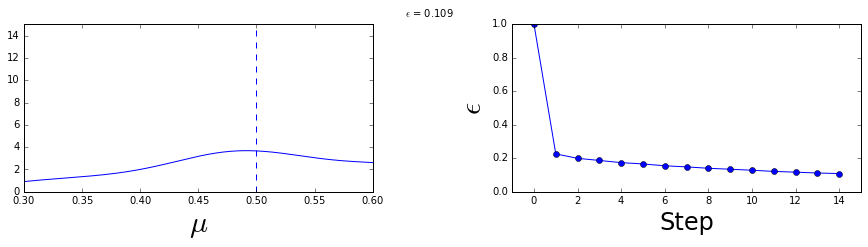

In [109]:
eps = []
for i in pmc_posterior:
    eps.append(i['epsilon'])
    mu = i[0][0]

    mukde = stats.gaussian_kde(mu)
    
    plt.figure(figsize=(15,3))
    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(r'$\epsilon$ = {:.3f}'.format(i['epsilon']))
    plt.subplot(121)
    x = np.linspace(bounds[0][0],bounds[0][1],1000)
    plt.plot(x, mukde(x))
    plt.axvline(alpha_value_0, ls='--')
    plt.ylim(0,15)
    plt.xlim(bounds[0][0],bounds[0][1])
    plt.xlabel(r"$\mu$", fontsize=30)

    plt.subplot(122)

    plt.plot(eps,'-o')
    plt.xlabel('Step', fontsize=24)
    plt.ylabel(r'$\epsilon$', fontsize=30)
    plt.xlim(-1,15)
    plt.ylim(0,1)

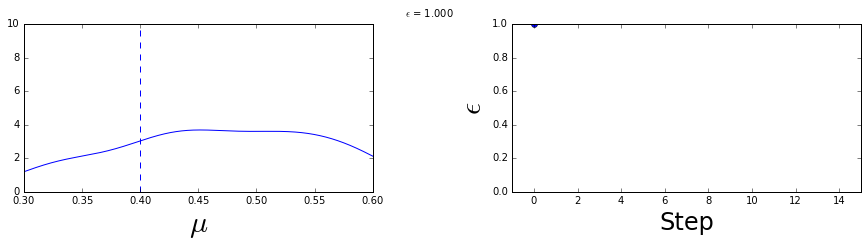

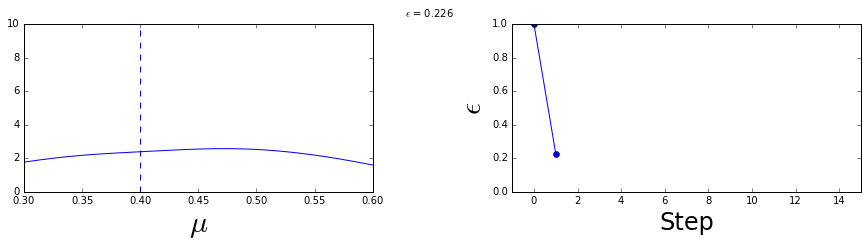

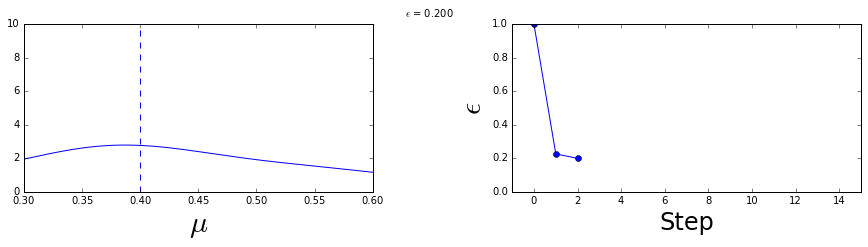

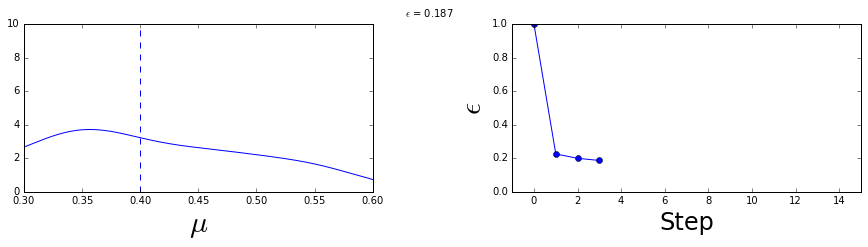

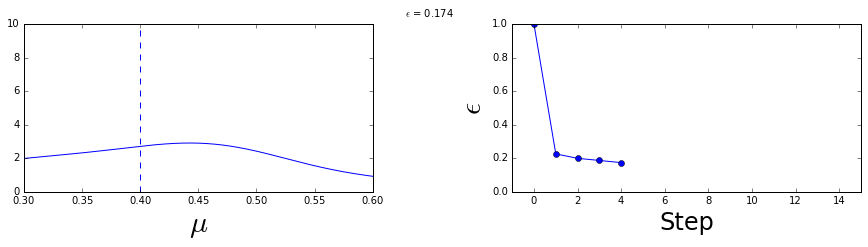

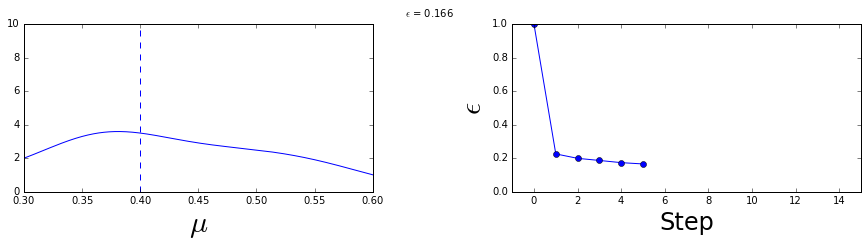

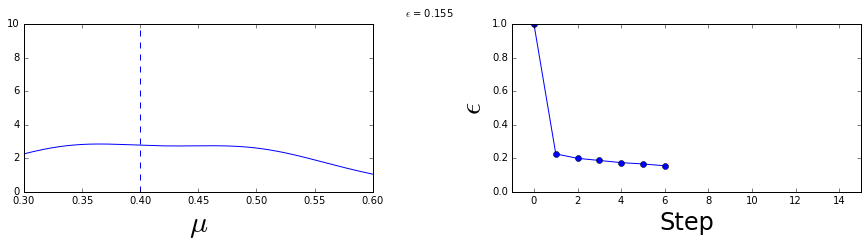

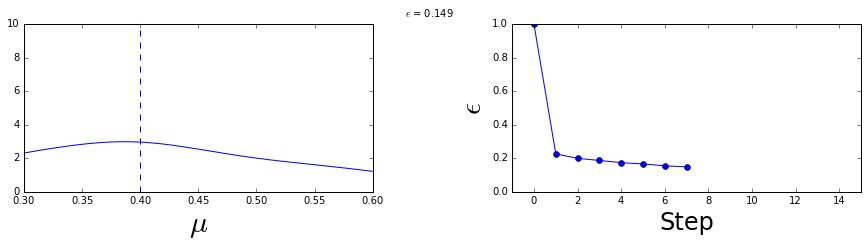

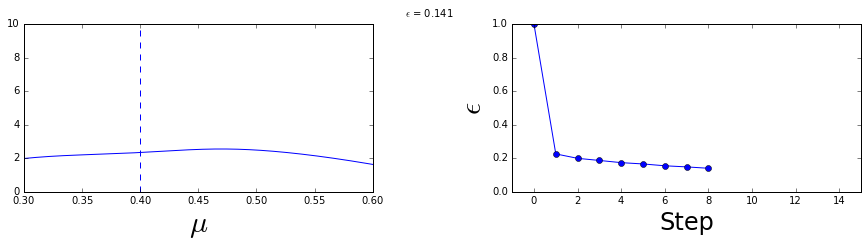

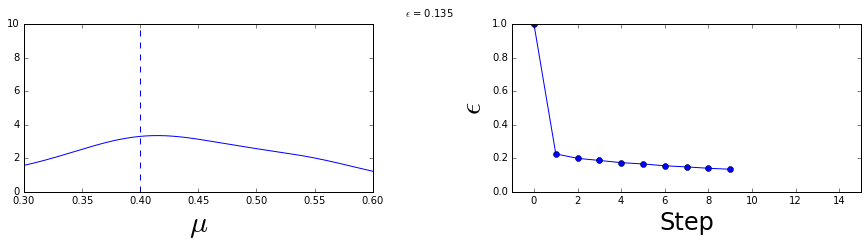

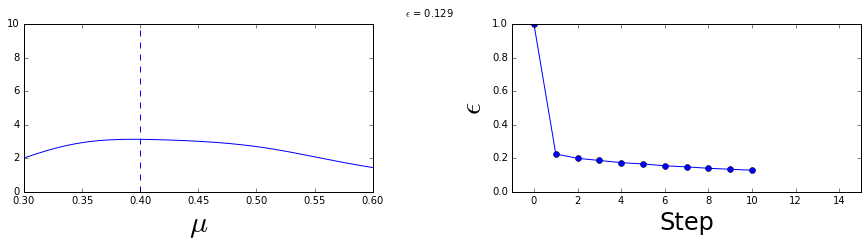

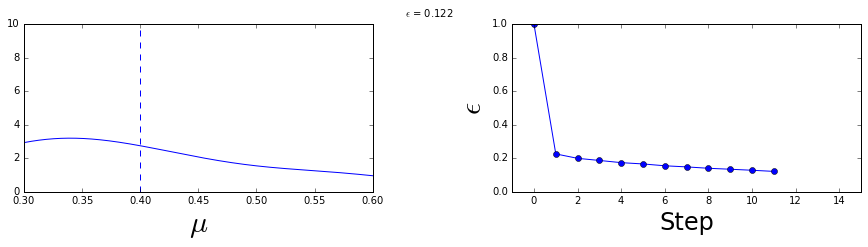

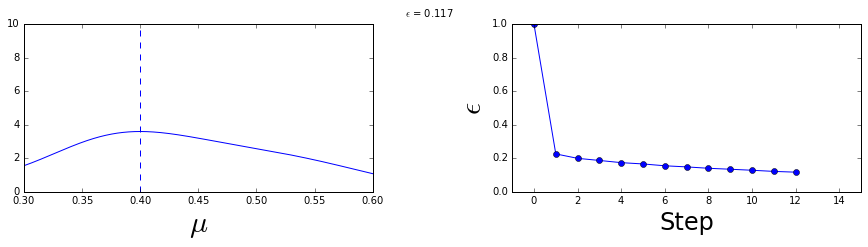

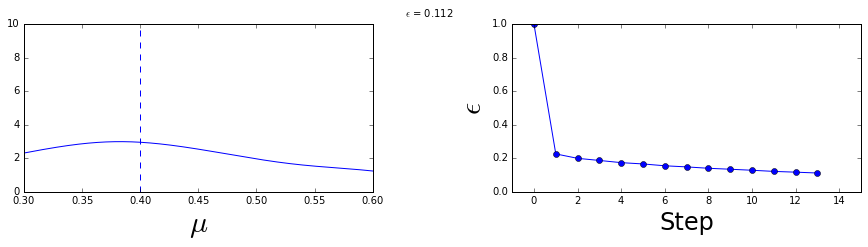

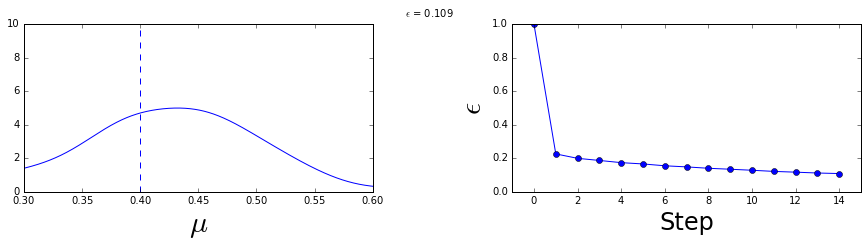

In [110]:
eps = []
for i in pmc_posterior:
    eps.append(i['epsilon'])
    mu = i[0][1]

    mukde = stats.gaussian_kde(mu)
    
    plt.figure(figsize=(15,3))
    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(r'$\epsilon$ = {:.3f}'.format(i['epsilon']))
    plt.subplot(121)
    x = np.linspace(bounds[1][0],bounds[1][1],1000)
    plt.plot(x, mukde(x))
    plt.axvline(alpha_value_1, ls='--')
    plt.ylim(0,10)
    plt.xlim(bounds[1][0],bounds[1][1])
    plt.xlabel(r"$\mu$", fontsize=30)

    plt.subplot(122)

    plt.plot(eps,'-o')
    plt.xlabel('Step', fontsize=24)
    plt.ylabel(r'$\epsilon$', fontsize=30)
    plt.xlim(-1,15)
    plt.ylim(0,1)

In [111]:
mu = pmc_posterior[-1][0]
print('Alpha 0 : {0} +/- {1}, Alpha 1: {2} +/- {3}'.format(
    mu[0].mean(), mu[0].std(), mu[1].mean(), mu[1].std()))

Alpha 0 : 0.500494916443 +/- 0.0989859237305, Alpha 1: 0.426616920322 +/- 0.0747469768664
